In [1]:
# Load the labeled data file and display the first 15 non-empty lines
file_path = "labeled_telegram_product_price_location.txt"

line_count = 0
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip() == "":
            # skip blank lines for this preview
            continue
        print(line.strip())
        line_count += 1
        if line_count >= 15:
            break


3pcs B-PRODUCT
silicon I-PRODUCT
brush I-PRODUCT
spatulas I-PRODUCT
እስከ O
260°c O
ሙቀት O
መቆቆም O
የሚችል O
ዋጋ-550ብር I-PRICE
አድራሻ O
ቁ.1 O
ስሪ O
ኤም O
ሲቲ O


In [2]:
# Validate format
num_lines = 0
num_sentences = 0
format_errors = 0
label_set = set()

with open(file_path, 'r', encoding='utf-8') as f:
    prev_blank = False
    for line in f:
        line = line.rstrip('\n')
        if line == "":
            # Blank line indicates end of a sentence
            num_sentences += 1
            prev_blank = True
            continue
        num_lines += 1
        parts = line.split()
        # Check for exactly 2 columns per non-blank line
        if len(parts) != 2:
            format_errors += 1
        else:
            token, label = parts
            label_set.add(label)
        prev_blank = False
    # If file doesn't end with a blank line, count the last sentence
    if not prev_blank:
        num_sentences += 1

print(f"Total tokens (non-blank lines): {num_lines}")
print(f"Total sentences (entries): {num_sentences}")
print(f"Unique labels in data: {sorted(label_set)}")
print(f"Formatting errors (lines not having 2 columns): {format_errors}")


Total tokens (non-blank lines): 174645
Total sentences (entries): 3166
Unique labels in data: ['B-PRODUCT', 'I-LOC', 'I-PRICE', 'I-PRODUCT', 'O']
Formatting errors (lines not having 2 columns): 0


In [3]:
from IPython.display import display, HTML

# Define colors for each entity type for highlighting
entity_colors = {
    "PRODUCT": "#ccffcc",  # light green
    "PRICE": "#ffffcc",    # light yellow
    "LOC": "#ccffff"       # light cyan
}

# Read the file and split into sentences (list of list of (token, label))
sentences = []
current_sentence = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.rstrip('\n')
        if line == "":
            if current_sentence:
                sentences.append(current_sentence)
                current_sentence = []
            continue
        token, label = line.split()
        current_sentence.append((token, label))
    # Append the last sentence if not already ended with a blank line
    if current_sentence:
        sentences.append(current_sentence)

# Function to create a highlighted HTML string for a sentence
def highlight_sentence(token_label_list):
    html_tokens = []
    for token, label in token_label_list:
        if label == 'O':
            # not an entity, no highlight
            html_tokens.append(token)
        else:
            # entity token: choose color based on entity type
            # entity type is the part after B- or I-
            ent_type = label.split('-')[-1]  
            color = entity_colors.get(ent_type, "#e0e0e0")  # default grey if unknown
            # Wrap token in a span with background color
            html_tokens.append(f"<span style='background-color: {color}'><b>{token}</b></span>")
    # Join tokens with space (NOTE: this might not perfectly reconstruct spacing/punctuation)
    return " ".join(html_tokens)

# Choose two sample sentences for demonstration (e.g., first two sentences in the dataset)
sample_indices = [0, 1]  # indices of sentences to display
for idx in sample_indices:
    sent = sentences[idx]
    highlighted_html = highlight_sentence(sent)
    print(f"Sentence {idx+1} (with highlighted entities):")
    display(HTML(highlighted_html))
    print("\n")  # newline for separation


Sentence 1 (with highlighted entities):




Sentence 2 (with highlighted entities):


In [4]:
from collections import Counter
# Count label frequencies
label_counts = Counter()
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line == "" or line.startswith("#"):
            continue  # skip empty lines and any comment lines (if any)
        _, label = line.split()
        label_counts[label] += 1

# Print out the counts for each label
for lbl, cnt in label_counts.items():
    print(f"{lbl}: {cnt}")


B-PRODUCT: 3055
I-PRODUCT: 11227
O: 148435
I-PRICE: 8195
I-LOC: 2869


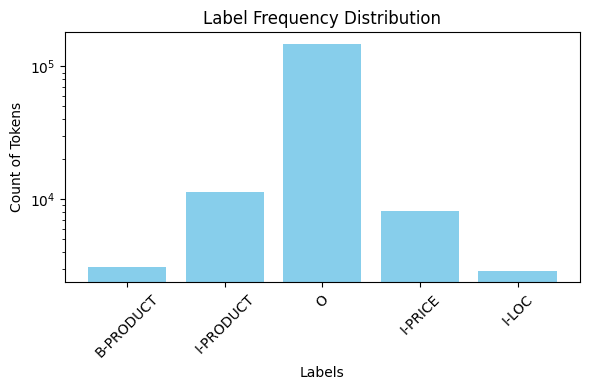

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = list(label_counts.keys())
counts = [label_counts[lbl] for lbl in labels]

plt.figure(figsize=(6,4))
plt.bar(labels, counts, color='skyblue')
plt.title("Label Frequency Distribution")
plt.xlabel("Labels")
plt.ylabel("Count of Tokens")
plt.xticks(rotation=45)
plt.yscale('log')  # using log scale to accommodate the wide range (O is much larger)
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd

# Build a DataFrame with columns: sentence_id, token, label
records = []
for sent_id, sent in enumerate(sentences):
    for token, label in sent:
        records.append((sent_id, token, label))

df = pd.DataFrame(records, columns=["sentence_id", "token", "label"])
print(df.shape)
df.head(10)


(174645, 3)


,sentence_id,token,label
0,0,3pcs,B-PRODUCT
1,0,silicon,I-PRODUCT
2,0,brush,I-PRODUCT
3,0,spatulas,I-PRODUCT
4,0,እስከ,O
5,0,260°c,O
6,0,ሙቀት,O
7,0,መቆቆም,O
8,0,የሚችል,O
9,0,ዋጋ-550ብር,I-PRICE


In [7]:
# Perform IOB tagging correction: convert I- at entity starts to B-
cleaned_sentences = []  # will hold lists of (token, label) for each sentence after cleaning
for sent in sentences:
    cleaned_sent = []
    prev_label = "O"
    for token, label in sent:
        if label.startswith("I-"):
            # If previous token was a different entity or outside, this I- should be B-
            if prev_label == "O" or prev_label.split('-')[-1] != label.split('-')[-1]:
                # Convert I-XXX to B-XXX
                label = "B-" + label[2:]
        # Append the (token, possibly corrected label)
        cleaned_sent.append((token, label))
        # Update prev_label (if current label is O, we keep it as "O"; else use the current entity type)
        prev_label = label if label != "O" else "O"
    cleaned_sentences.append(cleaned_sent)

# Verify new label distribution after cleaning
new_label_counts = Counter([lbl for sent in cleaned_sentences for _, lbl in sent])
print("New label counts after cleaning:")
for lbl, cnt in sorted(new_label_counts.items()):
    print(f"{lbl}: {cnt}")


New label counts after cleaning:
B-LOC: 2870
B-PRICE: 4763
B-PRODUCT: 3144
I-PRICE: 3441
I-PRODUCT: 11255
O: 149172


In [8]:
output_file = "labeled_telegram_product_price_location_cleaned.txt"
with open(output_file, 'w', encoding='utf-8') as out:
    for sent in cleaned_sentences:
        for token, label in sent:
            out.write(f"{token} {label}\n")
        out.write("\n")
print(f"Cleaned data has been written to {output_file}.")


Cleaned data has been written to labeled_telegram_product_price_location_cleaned.txt.


In [9]:
# Quick preview of the cleaned file (first 15 lines)
with open(output_file, 'r', encoding='utf-8') as f:
    preview_lines = [next(f).rstrip('\n') for _ in range(15)]
print("\n".join(preview_lines))


3pcs B-PRODUCT
silicon I-PRODUCT
brush I-PRODUCT
spatulas I-PRODUCT
እስከ O
260°c O
ሙቀት O
መቆቆም O
የሚችል O
ዋጋ-550ብር B-PRICE
አድራሻ O
ቁ.1 O
ስሪ O
ኤም O
ሲቲ O
